In [1]:
import numpy as np                                     # linear algebra
import pandas as pd                                    # data processing, CSV file I/O (e.g. pd.read_csv)
import copy                                            #to copy list
from sklearn.model_selection import train_test_split   #to split dataset into train and test set
from sklearn.svm import SVC                            #to create svc instance
from sklearn.metrics import classification_report      #to create report for precision,recall,f1-score,accuracy
from sklearn import metrics                            #to get accuracy
from sklearn.model_selection import GridSearchCV       #to optimise the hyper-parameter 
import pandas as pd 
import random
import string
import matplotlib.pyplot as plt 
%matplotlib inline

df = pd.read_csv("protine.csv")
#df = pd.read_csv('../input/anik3pssp/pdb-intersect-pisces.csv')

In [2]:
maxlen_seq = 4
input_seqs, target_seqs = df[['seq', 'sst3']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
#input_grams = seq2ngrams(input_seqs)
print(input_seqs[0:5])
print(input_seqs.size)

['EDK' 'KCK' 'KAK' 'KFK' 'KAK']
270


In [3]:
print(target_seqs[0:5])
print(target_seqs.size)
print(len(target_seqs))
print(len(target_seqs[0]))

['CEC' 'CEC' 'CEC' 'CEC' 'CEC']
270
270
3


In [4]:
for row in range(len(target_seqs)):
    secondary_lenth = len(target_seqs[row])
    primary_lenth = len(input_seqs[row])
    
    if(secondary_lenth != primary_lenth):
        print("(",row,") Secondary_Structure ->", target_seqs[row]," Primary_Structure -> ",input_seqs[row])

In [5]:
secondary_count = 0
primary_count = 0
for row in range(len(target_seqs)):
    secondary_lenth = len(target_seqs[row])
    primary_lenth = len(input_seqs[row])
    secondary_count = secondary_count + secondary_lenth
    primary_count = primary_count + primary_lenth
    if(secondary_lenth != primary_lenth):
        print("(",row,") Secondary_Structure ->", target_seqs[row]," Primary_Structure -> ",input_seqs[row])
        
print("count of secondary structure : ",secondary_count)
print("count of primary structure : ",primary_count)

count of secondary structure :  961
count of primary structure :  961


In [6]:
#sequence="EDK"
def split(sequence): 
    return [char for char in sequence]

In [7]:
primary_split = []
secondary_split = []
for row in range(int(len(target_seqs)/40)):
    primary_split.append(split(input_seqs[row]))
    secondary_split.append(split(target_seqs[row]))

In [8]:
def orthogonal_primary(arg):
    switch = {
        'A' : np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),  # 20 amino acids
        'C' : np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'E' : np.array([0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'D' : np.array([0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'G' : np.array([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'F' : np.array([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'I' : np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'H' : np.array([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]),
        'K' : np.array([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]),
        'M' : np.array([0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]),
        'L' : np.array([0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]),
        'N' : np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]),
        'Q' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]),
        'P' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]),
        'S' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]),
        'R' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]),
        'T' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]),
        'W' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]),
        'V' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]),
        'Y' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1])
    }
    
    return switch.get(arg)

def orthogonal_secondary(arg):
    switch = {
        'H' : 0,                    # H= α-helix
        'C' : 1,                    # C= Loops and irregular elements
        'E' : 2,                    # E= β-strand
        'B' : 3,                    # B= β-bridge
        'G' : 4,                    # G= 3-helix
        'I' : 5,                    # I= π-helix
        'T' : 6,                    # T= Turn
        'S' : 7                     # S= Bend
    }
    
    return switch.get(arg)

In [9]:
#print(len(primary_split))
#print(len(secondary_split))
for row in range(len(primary_split)):  
    sequence = primary_split[row]
    for col in range(len(sequence)):
        #print(sequence[col])
        sequence[col] = orthogonal_primary(sequence[col])
        #print(sequence[col])

In [10]:
for row in range(len(secondary_split)):  
    sequenceS = secondary_split[row]
    for col in range(len(sequenceS)):
        sequenceS[col] = orthogonal_secondary(sequenceS[col])

In [11]:
primary_split[0:5]

[[array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  

In [12]:
secondary_split[0:5]

[[1, 2, 1], [1, 2, 1], [1, 2, 1], [1, 2, 1], [1, 2, 1]]

In [13]:
def graph_sum2(seq1,seq2):
    result = [None]*len(seq1)
    for col in range(len(seq1)):
        result[col] =  seq1[col]+seq2[col]
    return result


def graph_sum3(seq1,seq2,seq3):
    result = [None]*len(seq1)
    for col in range(len(seq1)):
        result[col] =  seq1[col]+seq2[col]+seq3[col]
    return result

In [14]:
graph_input = copy.deepcopy(primary_split)
for row in range(len(primary_split)):
    sequence = primary_split[row]
    graph_input[row][0]=graph_sum2(sequence[0],sequence[1])
    graph_input[row][len(sequence)-1]=graph_sum2(sequence[len(sequence)-1],sequence[len(sequence)-2])
    for col in range(1,len(sequence)-1):
        graph_input[row][col] = graph_sum3(sequence[col-1],sequence[col],sequence[col+1])
        
graph_input[0:5]

[[[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]

In [15]:
def targetY(data_list):
    Y = []
    for i in range(len(data_list)):
        for j  in range(len(data_list[i])):
            Y.append(data_list[i][j])
    return Y

In [16]:
y_label = targetY(secondary_split)

In [17]:
print(len(y_label))
print(y_label[0:5])

18
[1, 2, 1, 1, 2]


In [18]:
def window_padding_data(size, sequence):
    num = int(size/2)
    #print("initial :",sequence[0])
    #print("")
    zeros = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    for i in range(len(sequence)):
        for j in range(num):
            sequence[i].append(zeros)
            sequence[i].insert(0, zeros)
            #print(sequence[i])
            #print("")
            
    X = []
    temp = []

    for k in range(len(sequence)):
        #print(sequence[k])
        for l in range(len(sequence[k])-(size-1)):
            temp = sequence[k][l:l+size]
           # print(temp)
            X.append(temp)
            temp = []

    return X

In [19]:
X = window_padding_data(11,graph_input)
len(X)
X[0:5]

[[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0,

In [20]:
np.set_printoptions(threshold=np.inf)
X = np.array(X)
y_label = np.array(y_label)
X = X.reshape(len(X),11*20)
print(X[0:5])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 

In [21]:
#split the dataset into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size = 0.20,random_state=54)

In [22]:
#print(X_train.shape)
print(y_train.shape)

(14,)


In [23]:
#for i in range(1,101):
#    X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size = 0.20,random_state=i)
svc = SVC(kernel='rbf', gamma = 0.1, C=1.7)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test )
y_true = y_test
#    print("i = ",i,"acc = ",metrics.accuracy_score(y_test, y_pred))
print("Accuracy = ",metrics.accuracy_score(y_test, y_pred)*100)
print(classification_report(y_true,y_pred))

Accuracy =  100.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [24]:
print(X_test.size)
print(y_pred.size)
#print(X_test.size)
print(y_true.size)
#print(y_true[0:1080])

880
4
4


In [25]:
gnn_ensemble = np.empty(shape = (y_pred.shape))
for i in range(len(y_pred)):
    if(y_pred[i]==y_true[i]):
        gnn_ensemble[i]=1
    else:
        gnn_ensemble[i]=0

In [26]:
gnn_ensemble

array([1., 1., 1., 1.])

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

rf = RandomForestClassifier(n_estimators=5, random_state=54)
gb = GradientBoostingClassifier(random_state=54)
dt = DecisionTreeClassifier(random_state=54)
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1)
neigh = KNeighborsClassifier(n_neighbors=3)
clf = VotingClassifier(estimators=[("rf", rf), ("gb", gb), ("dt", dt)], voting="hard")
clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=5,
                                                     random_state=54)),
                             ('gb',
                              GradientBoostingClassifier(random_state=54)),
                             ('dt', DecisionTreeClassifier(random_state=54))])

In [28]:
#print(X_train)
#print(y_train)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print("DT Accuracy:", accuracy)

DT Accuracy: 1.0


In [29]:
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print("GB Accuracy:", accuracy)

GB Accuracy: 1.0


In [30]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print("RF Accuracy:", accuracy)

RF Accuracy: 0.75


In [31]:
model = abc.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print("AdaBoost Accuracy:", accuracy)

AdaBoost Accuracy: 1.0


In [32]:
model = neigh.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print("KNeighbors Accuracy:", accuracy)

KNeighbors Accuracy: 1.0


In [33]:
from sklearn.metrics import recall_score, precision_score, f1_score
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [34]:
maxlen_seq = 4
input_seqs, target_seqs = df[['seq', 'sst3']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
#input_grams = seq2ngrams(input_seqs)
print(input_seqs[0:5])
print(input_seqs.size)

['EDK' 'KCK' 'KAK' 'KFK' 'KAK']
270


In [35]:
def seq2ngrams(seqs, n=2):
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])

In [36]:
input_grams = seq2ngrams(input_seqs)

C:\Users\User\AppData\Local\Temp\ipykernel_6820\2877315036.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])


In [37]:
print(input_seqs[0])
print(target_seqs[0])
print(input_grams[0])

EDK
CEC
['ED', 'DK', 'K']


In [38]:
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(input_grams)
input_data = tokenizer_encoder.texts_to_sequences(input_grams)
print(input_data[0])
input_data = sequence.pad_sequences(input_data, maxlen=maxlen_seq, padding='post')
print(input_data[0])
#input_data = to_categorical(input_data)

tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
#print(tokenizer_decoder.fit_on_texts(target_seqs))
print(target_seqs[0])
print(target_seqs[1])
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
print(target_data[0])
print(target_data[1])
target_data = sequence.pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
print(target_data[0])
print(target_data[1])
target_data = to_categorical(target_data)

print(input_data.shape, target_data.shape)
#print(input_data.size)
#print(target_data.size)
#print(input_data)
#print(target_data)
print(input_data[0])
print(target_data[0])

[108, 71, 5]
[108  71   5   0]
CEC
CEC
[1, 2, 1]
[1, 2, 1]
[1 2 1 0]
[1 2 1 0]
(270, 4) (270, 4, 3)
[108  71   5   0]
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [39]:
print(input_seqs.shape)
print(input_seqs[1], target_seqs[1])
print(input_data.shape)
print(input_data[1], target_data[1])

(270,)
KCK CEC
(270, 4)
[109 110   5   0] [[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [40]:
print(input_seqs[0])
print(target_seqs[0])
print(input_data[0])
print(target_data[0])

EDK
CEC
[108  71   5   0]
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding, Dense, TimeDistributed, Bidirectional, Conv1D, Flatten, LSTM
from tensorflow.keras.models import Sequential

n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(tokenizer_encoder.word_index)
print("Tokenizer decoder result")
print(tokenizer_decoder.word_index)
print(n_words, n_tags)

input = Input(shape=(maxlen_seq,))
x = Embedding(input_dim=n_words, output_dim=256, input_length=maxlen_seq)(input)
#x = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(x)
x = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.2))(x)
#x = LSTM(units=64, return_sequences=True, recurrent_dropout=0.1)(x)
x = Sequential(Dense(units=64))(x)
#r = (Flatten())(x)
p = (Dense(128, activation="relu"))(x)
y = (Dense(64, activation="relu"))(p)
z = TimeDistributed(Dense(n_tags, activation="softmax"))(y)
model = Model(input, z)
model.summary()

{'aa': 1, 'a': 2, 'rp': 3, 'p': 4, 'k': 5, 'pr': 6, 'hr': 7, 'gh': 8, 'r': 9, 'ka': 10, 'f': 11, 's': 12, 'gp': 13, 'v': 14, 'fp': 15, 'l': 16, 'kg': 17, 'ma': 18, 'ga': 19, 'ak': 20, 'as': 21, 'rv': 22, 'we': 23, 'ee': 24, 'el': 25, 'e': 26, 'av': 27, 'vp': 28, 'w': 29, 'll': 30, 'ge': 31, 'i': 32, 'ar': 33, 'lf': 34, 'rk': 35, 'ia': 36, 'kk': 37, 'sr': 38, 'y': 39, 'vr': 40, 'is': 41, 'se': 42, 'ev': 43, 'gl': 44, 'g': 45, 'pf': 46, 'gk': 47, 'ag': 48, 'lt': 49, 't': 50, 'pg': 51, 'kf': 52, 'kp': 53, 'kn': 54, 'vk': 55, 'kl': 56, 'ap': 57, 'ek': 58, 'ai': 59, 'la': 60, 'ie': 61, 'pi': 62, 'qe': 63, 'ti': 64, 'fg': 65, 'et': 66, 'at': 67, 'ta': 68, 'lv': 69, 'ps': 70, 'dk': 71, 'fk': 72, 'ki': 73, 'sk': 74, 'tk': 75, 'kv': 76, 'lk': 77, 'kw': 78, 'nl': 79, 'rs': 80, 'ra': 81, 'ql': 82, 'qi': 83, 'ii': 84, 'aw': 85, 'vy': 86, 'ts': 87, 'al': 88, 'pw': 89, 'vs': 90, 'td': 91, 'd': 92, 'tv': 93, 'pv': 94, 'rr': 95, 'sd': 96, 'de': 97, 'ef': 98, 'sq': 99, 'ey': 100, 'pq': 101, 'qt': 102, 

In [42]:
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
from keras import backend  as K
import tensorflow as tf

#model = m

def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc])

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.2, random_state=54)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.2, random_state=54)

history=model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
4/4 [==============================] - 14s 608ms/step - loss: 1.0441 - accuracy: 0.5590 - q3_acc: 0.6191 - val_loss: 0.8488 - val_accuracy: 0.6111 - val_q3_acc: 0.6650
Epoch 2/20
4/4 [==============================] - 0s 58ms/step - loss: 0.7822 - accuracy: 0.6620 - q3_acc: 0.6662 - val_loss: 0.6566 - val_accuracy: 0.6944 - val_q3_acc: 0.6650
Epoch 3/20
4/4 [==============================] - 0s 53ms/step - loss: 0.6065 - accuracy: 0.7049 - q3_acc: 0.6662 - val_loss: 0.5278 - val_accuracy: 0.7176 - val_q3_acc: 0.6904
Epoch 4/20
4/4 [==============================] - 0s 53ms/step - loss: 0.4838 - accuracy: 0.7662 - q3_acc: 0.7356 - val_loss: 0.4310 - val_accuracy: 0.8935 - val_q3_acc: 0.8832
Epoch 5/20
4/4 [==============================] - 0s 55ms/step - loss: 0.3568 - accuracy: 0.8785 - q3_acc: 0.8626 - val_loss: 0.4161 - val_accuracy: 0.8796 - val_q3_acc: 0.8680
Epoch 6/20
4/4 [==============================] - 0s 57ms/step - loss: 0.2627 - accuracy: 0.9363 - q3_acc: 0.9280

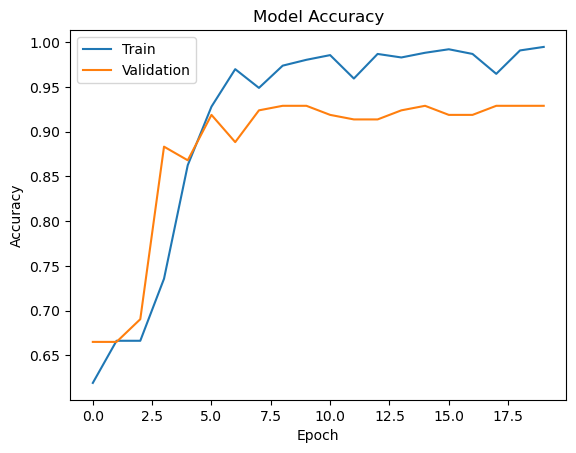

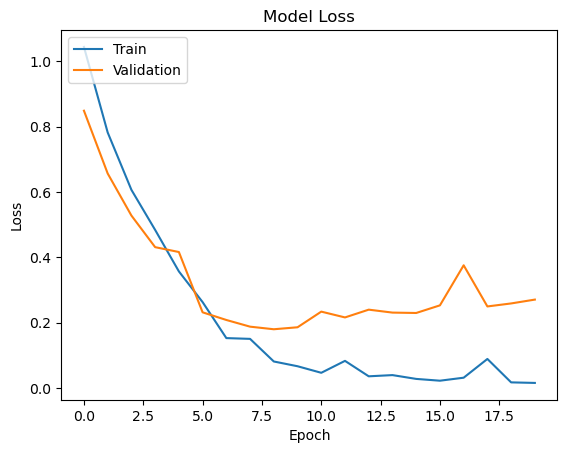

In [43]:
# summarize history for accuracy
plt.plot(history.history['q3_acc'])
plt.plot(history.history['val_q3_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [44]:
#print(X_test.size)
print(y_pred.size)
print(y_true.size)

4
4


In [45]:
bilstm_ensemble = np.empty(shape = (y_pred.shape))
for i in range(len(y_pred)):
    if(y_pred[i]==y_true[i]):
        bilstm_ensemble[i]=1
    else:
        bilstm_ensemble[i]=0

In [46]:
bilstm_ensemble

array([1., 1., 1., 1.])

In [47]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [48]:
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Embedding, Dense, TimeDistributed, Bidirectional, Conv1D, Flatten, LSTM
from keras.models import Sequential

n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

input = Input(shape=(maxlen_seq,))
x = Embedding(input_dim=n_words, output_dim=256, input_length=maxlen_seq)(input)
#x = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(x)
x = LSTM(units=64, return_sequences=True, recurrent_dropout=0.1)(x)
x = Sequential(Dense(units=64))(x)
#r = (Flatten())(x)
p = (Dense(128, activation="relu"))(x)
y = (Dense(64, activation="relu"))(p)
z = TimeDistributed(Dense(n_tags, activation="softmax"))(y)
model = Model(input, z)
model.summary()

185 3
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 embedding_1 (Embedding)     (None, 4, 256)            47360     
                                                                 
 lstm_1 (LSTM)               (None, 4, 64)             82176     
                                                                 
 sequential_1 (Sequential)   (None, 4, 64)             4160      
                                                                 
 dense_5 (Dense)             (None, 4, 128)            8320      
                                                                 
 dense_6 (Dense)             (None, 4, 64)             8256      
                                                                 
 time_distributed_1 (TimeDis  (None, 4, 3)           

In [49]:
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
from keras import backend  as K
import tensorflow as tf
#model = m

def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc])

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.2, random_state=54)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.2, random_state=54)
history=model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
4/4 [==============================] - 9s 503ms/step - loss: 1.0702 - accuracy: 0.4780 - q3_acc: 0.4987 - val_loss: 0.9610 - val_accuracy: 0.6944 - val_q3_acc: 0.6650
Epoch 2/20
4/4 [==============================] - 0s 44ms/step - loss: 0.8912 - accuracy: 0.6933 - q3_acc: 0.6662 - val_loss: 0.7325 - val_accuracy: 0.6944 - val_q3_acc: 0.6650
Epoch 3/20
4/4 [==============================] - 0s 44ms/step - loss: 0.6694 - accuracy: 0.7049 - q3_acc: 0.6662 - val_loss: 0.5817 - val_accuracy: 0.6944 - val_q3_acc: 0.6650
Epoch 4/20
4/4 [==============================] - 0s 48ms/step - loss: 0.5192 - accuracy: 0.7199 - q3_acc: 0.6832 - val_loss: 0.4603 - val_accuracy: 0.7315 - val_q3_acc: 0.7056
Epoch 5/20
4/4 [==============================] - 0s 42ms/step - loss: 0.3903 - accuracy: 0.8414 - q3_acc: 0.8207 - val_loss: 0.3627 - val_accuracy: 0.8287 - val_q3_acc: 0.8122
Epoch 6/20
4/4 [==============================] - 0s 42ms/step - loss: 0.2909 - accuracy: 0.8900 - q3_acc: 0.8757 

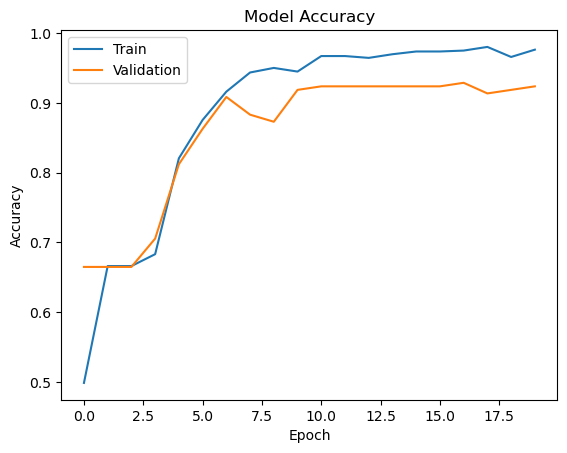

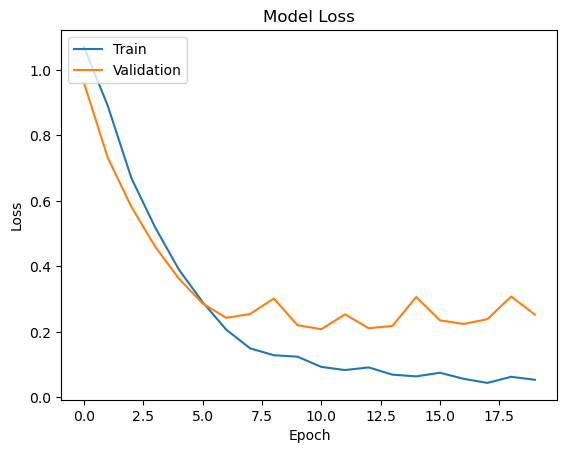

In [50]:
# summarize history for accuracy
plt.plot(history.history['q3_acc'])
plt.plot(history.history['val_q3_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [51]:
#print(X_test.size)
print(y_pred.size)
print(y_true.size)

4
4


In [52]:
lstm_ensemble = np.empty(shape = (y_pred.shape))
for i in range(len(y_pred)):
    if(y_pred[i]==y_true[i]):
        lstm_ensemble[i]=1
    else:
        lstm_ensemble[i]=0

In [53]:
lstm_ensemble

array([1., 1., 1., 1.])

In [54]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [55]:
count_true=0
count_false=0
for i in range(len(y_pred)):
    if(gnn_ensemble[i]+bilstm_ensemble[i]+lstm_ensemble[i]>=2):
        count_true+=1
    else:
        count_false+=1

In [56]:
print(count_true)
print(count_false)

4
0


In [57]:
accuracy=((count_true)*100)/(y_pred.size)
print(accuracy)

100.0


In [58]:
y_test_pred = model.predict(X_test)

2/2 [==============================] - 1s 0s/step


In [59]:
y_train_pred = model.predict(X_train)

7/7 [==============================] - 0s 10ms/step


In [60]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

In [61]:
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

In [62]:
N=500
print("Training----------------------------")
for i in range(N):
    print("Input: " + seq_train[i])
    print("Target: " + onehot_to_seq(y_train[i], revsere_decoder_index).upper())
    print("Result: " + onehot_to_seq(y_train_pred[i], revsere_decoder_index).upper())
    print()

Training----------------------------
Input: RVRK
Target: CCEC
Result: CCEC

Input: LLL
Target: CEC
Result: CEC

Input: FPR
Target: CEC
Result: CEC

Input: ISEV
Target: CEEC
Result: CEEC

Input: LDPR
Target: CEEC
Result: CEEC

Input: FPR
Target: CEC
Result: CEC

Input: FGLF
Target: CCEC
Result: CCEC

Input: FPR
Target: CEC
Result: CEC

Input: GHRP
Target: CECC
Result: CECC

Input: FPR
Target: CEC
Result: CEC

Input: AVPW
Target: CEEC
Result: CEEC

Input: GKGA
Target: CCCC
Result: CCCC

Input: FGLF
Target: CCEC
Result: CCEC

Input: KAA
Target: CEC
Result: CEC

Input: LSRS
Target: CEEC
Result: CEEC

Input: EQW
Target: CEC
Result: CEC

Input: KMK
Target: CEC
Result: CEC

Input: KAA
Target: CEC
Result: CEC

Input: ISEV
Target: CEEC
Result: CEEC

Input: MAS
Target: CEC
Result: CEC

Input: TITS
Target: CECC
Result: CECC

Input: DRVY
Target: CCEC
Result: CCEC

Input: QII
Target: CEC
Result: CEC

Input: YRF
Target: CEC
Result: CEC

Input: GHRP
Target: CECC
Result: CECC

Input: RVRK
Target: CCEC

IndexError: index 216 is out of bounds for axis 0 with size 216

In [63]:
N=500
print("Testing----------------------------")
for i in range(N):
    print("Input: " + seq_test[i])
    print("Target: " + onehot_to_seq(y_test[i], revsere_decoder_index).upper())
    print("Result: " + onehot_to_seq(y_test_pred[i], revsere_decoder_index).upper())
    print()

Testing----------------------------
Input: ISEV
Target: CEEC
Result: CEEC

Input: KKK
Target: CEC
Result: CEC

Input: GPRP
Target: CECC
Result: CECC

Input: AVPF
Target: CEEC
Result: CEEC

Input: AAAA
Target: CEEC
Result: CEEC

Input: RVRK
Target: CCEC
Result: CCEC

Input: KAA
Target: CEC
Result: CEC

Input: VSRR
Target: CCEC
Result: CEEC

Input: WEEL
Target: CEEC
Result: CEEC

Input: KAK
Target: CEC
Result: CEC

Input: ENW
Target: CEC
Result: CCC

Input: GAR
Target: CEC
Result: CEC

Input: APR
Target: CEC
Result: EEC

Input: AAAA
Target: CEEC
Result: CEEC

Input: FPR
Target: CEC
Result: CEC

Input: GATV
Target: CCEC
Result: CEEC

Input: KFK
Target: CEC
Result: CEC

Input: AAAA
Target: CCEC
Result: CEEC

Input: PGVY
Target: CCEC
Result: CCEC

Input: WEEL
Target: CEEC
Result: CEEC

Input: GAK
Target: CEC
Result: CEC

Input: LVVN
Target: CCEC
Result: CECC

Input: WEEL
Target: CEEC
Result: CEEC

Input: AVPI
Target: CEEC
Result: CEEC

Input: AAAA
Target: CCEC
Result: CEEC

Input: RVRK
Targ

IndexError: index 54 is out of bounds for axis 0 with size 54

In [79]:
print(seq_train[42])
print(y_train[42])
print(y_train_pred[42])

EDK
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[3.4799948e-04 9.9897885e-01 6.7320780e-04]
 [5.9440877e-06 2.6322843e-03 9.9736178e-01]
 [6.3474988e-07 9.9999231e-01 7.0184633e-06]
 [9.9960119e-01 3.9833592e-04 5.1524535e-07]]


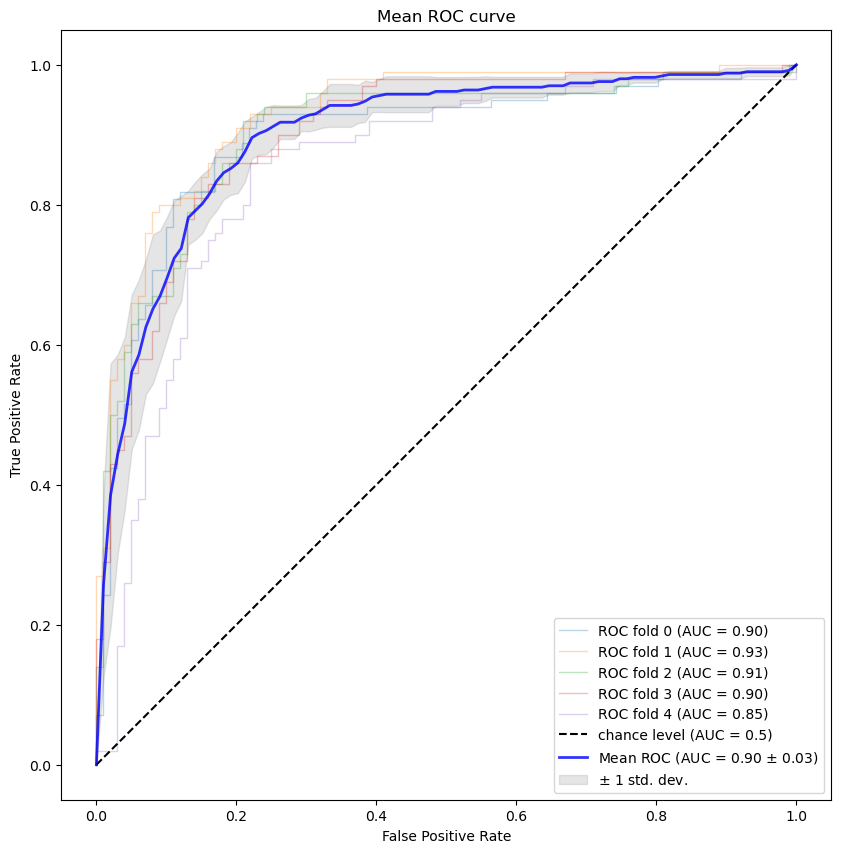

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5) 
classifier = svm.SVC(kernel='rbf', gamma = 0.1, C=1.7)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10, 10))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Mean ROC curve",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.903


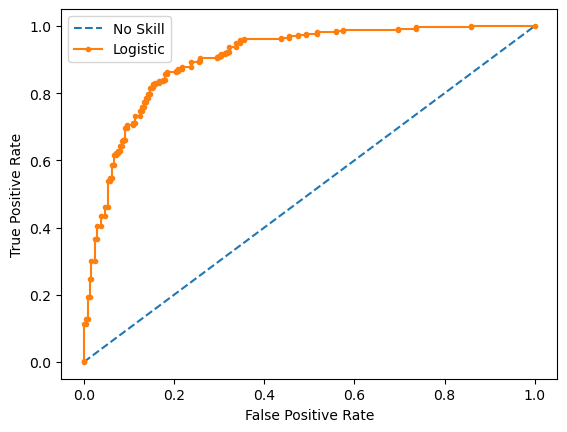

In [66]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()